## Device
Adjust your paths


In [2]:
shared_folder_Path = "//media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/ABONA_MEENA/shared"[:-6]
path_model = "/media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/⭐⭐⭐⭐⭐⭐⭐/TwoEnc_SumSeDec/"
paths_names = "/media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/0_Data/Old_IXI/names-shared/"
data_path = '/media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/0_Data/Old_IXI/'

In [3]:
import sys,os, glob
sys.path.insert(1,shared_folder_Path)

try:
    os.mkdir(path_model)
except:
    pass

import pickle
with open (paths_names+'train_Names.pkl', 'rb') as fp:
    train_images = pickle.load(fp)
with open (paths_names+'test_Names.pkl', 'rb') as fp:
    test_images = pickle.load(fp)

paths_train = [data_path+'IXI_T2_Train/IXI_T2_Train/'+i for i in train_images][:30000]
paths_test = [data_path+'IXI_T2_Test/IXI_T2_Test/'+i for i in    test_images][:]

device = "cuda"

## Import

In [4]:
%load_ext autoreload
%autoreload 2

import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import random
from tqdm import tqdm
from shared.plot import plot_2_Imgs, plot_3_Imgs, plot_4_Imgs, plot_Img
from shared.ssim import SSIM
ssim_calc = SSIM()


def get_n_params( model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn

    return pp


# Deterministic for spectral norm
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

def init_seeds(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(0)
    # no change in alg
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True)
init_seeds(42)

## Data

In [5]:
import pywt
import albumentations as A
aug = A.Resize(256, 256, p=1)

def FREQ_WaveLet(Imgall):
    Los = []; Highs = []
    try:
        Imgall = Imgall.cpu().detach()
    except:
        pass
    for Img in Imgall:
        image = Img[0]
        LL, (LH, HL, HH) = pywt.dwt2(image, "db2")
        LowImg = aug(image=LL)['image']
        
        mix = LH+ HL+ HH
        HighImg = aug(image=mix)['image']

        Los.append(torch.tensor(LowImg)[None])
        Highs.append(torch.tensor(HighImg)[None])
    return torch.stack(Los), torch.stack(Highs)

/media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/ABONA_MEENA/VENV_FASTMRI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/ABONA_MEENA/VENV_FASTMRI/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
from torch.utils.data import Dataset, DataLoader
class MRIDataset(Dataset):
    def __init__(self, imgs_paths):
        self.imgs_paths = imgs_paths
    
    def __len__(self):
        return len(self.imgs_paths)

    def norm(self,arr):
        arr = 2*((arr - arr.min()) / (arr.max()-arr.min()))-1
        return arr
    
    def norm_0_1(self,arr):
        arr = ((arr - arr.min()) / (arr.max()-arr.min()))
        return arr

    def __getitem__(self, index):
        Main_Artifact_path = self.imgs_paths[index]
        arr = torch.load(Main_Artifact_path, weights_only=True).type(torch.float32) # convert to CNN input type

        Img_arr = arr[0]
        LowFreqArr,HighFreqArr = FREQ_WaveLet(Img_arr[None][None])
        LowFreqArr,HighFreqArr = LowFreqArr[0,0],HighFreqArr[0,0]
        LowFreqArr,HighFreqArr = self.norm_0_1(LowFreqArr),self.norm_0_1(HighFreqArr)

        Img_artifact = arr[1]
        LowFreqartifact,HighFreqartifact = FREQ_WaveLet(Img_artifact[None][None])
        LowFreqartifact,HighFreqartifact = LowFreqartifact[0,0],HighFreqartifact[0,0]
        LowFreqartifact,HighFreqartifact = self.norm_0_1(LowFreqartifact),self.norm_0_1(HighFreqartifact)

        num_diff = 6

        # Priors
        num =  int(Main_Artifact_path[ Main_Artifact_path.find("slice")+num_diff:Main_Artifact_path.find(".pt")])
        path_aft = Main_Artifact_path[:Main_Artifact_path.find("slice")+num_diff] + str(num+1) + ".pt"
        path_bef = Main_Artifact_path[:Main_Artifact_path.find("slice")+num_diff] + str(num-1) + ".pt"
   
        try:
            bef_art = torch.load(path_bef, weights_only=True).type(torch.float32)[1]
        except:
            bef_art = Img_artifact


        try:
            aft_art = torch.load(path_aft, weights_only=True).type(torch.float32)[1]
        except:
            aft_art = Img_artifact

        LowFreq_bef_art,HighFreq_bef_art = FREQ_WaveLet(bef_art[None][None])
        LowFreq_bef_art,HighFreq_bef_art = LowFreq_bef_art[0,0],HighFreq_bef_art[0,0]
        LowFreq_bef_art,HighFreq_bef_art = self.norm_0_1(LowFreq_bef_art),self.norm_0_1(HighFreq_bef_art)

        LowFreq_aft_art,HighFreq_aft_art = FREQ_WaveLet(aft_art[None][None])
        LowFreq_aft_art,HighFreq_aft_art = LowFreq_aft_art[0,0],HighFreq_aft_art[0,0]
        LowFreq_aft_art,HighFreq_aft_art = self.norm_0_1(LowFreq_aft_art),self.norm_0_1(HighFreq_aft_art)

        aft_art = self.norm(aft_art)
        bef_art = self.norm(bef_art)
        Img_arr = self.norm(Img_arr)
        Img_artifact = self.norm(Img_artifact)
        return  {"Arr":Img_arr[None,...], "Art":Img_artifact[None,...],\
                "LowFreqArr":LowFreqArr[None,...],"HighFreqArr":HighFreqArr[None,...],\
                "LowFreqArt":LowFreqartifact[None,...],"HighFreqArt":HighFreqartifact[None,...],
                 "path":Main_Artifact_path,
                "befArt":bef_art[None,...], "aftArt":aft_art[None,...],
                "LowFreq_bef_art":LowFreq_bef_art[None,...], "HighFreq_befArt":HighFreq_bef_art[None,...],
                "LowFreq_aft_art":LowFreq_aft_art[None,...], "HighFreq_aft_art":HighFreq_aft_art[None,...]}


dataset_train = MRIDataset(paths_train)
dataset_val = MRIDataset(paths_test)

print(len(dataset_train), len(dataset_val))

30000 12960


In [7]:
batch_size = 8

dataloaders = dict()
dataloaders['train'] = DataLoader(dataset_train, batch_size=batch_size,
                                   shuffle=True, pin_memory=True)
dataloaders['val'] = DataLoader(dataset_val, batch_size=batch_size,
                                shuffle=False, pin_memory=True)

/media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/0_Data/Old_IXI/IXI_T2_Test/IXI_T2_Test/High_IXI603-HH-2701-T2_slice_89.pt
tensor(-1.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


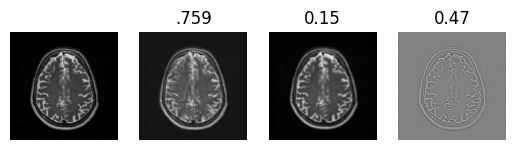

tensor(-1.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


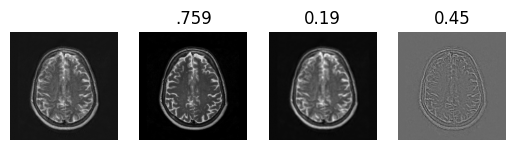

tensor(-1.) tensor(1.)
tensor(-1.) tensor(1.)
tensor(0.) tensor(1.)


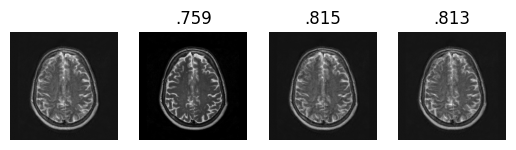

In [8]:
s = random.randint(0,len(dataset_val))
sample = dataset_val[s]
print( sample['path'])
print(sample['Arr'][0].min(), sample['Arr'][0].max())
print(sample['LowFreqArr'][0].min(), sample['LowFreqArr'][0].max())
print(sample['HighFreqArr'][0].min(), sample['HighFreqArr'][0].max())
plot_4_Imgs(sample['Arr'][0], sample['Art'][0], sample['LowFreqArr'][0],sample['HighFreqArr'][0],rotate=True)

print(sample['Art'][0].min(), sample['Art'][0].max())
print(sample['LowFreqArt'][0].min(), sample['LowFreqArt'][0].max())
print(sample['HighFreqArt'][0].min(), sample['HighFreqArt'][0].max())
plot_4_Imgs(sample['Art'][0], sample['Arr'][0], sample['LowFreqArt'][0],sample['HighFreqArt'][0],rotate=True)


print(sample['befArt'][0].min(), sample['befArt'][0].max())
print(sample['aftArt'][0].min(), sample['aftArt'][0].max())
print(sample['LowFreq_aft_art'][0].min(), sample['LowFreq_aft_art'][0].max())
plot_4_Imgs(sample['Art'][0], sample['Arr'][0], sample['befArt'][0], sample['aftArt'][0],rotate=True)

## Model

initialize network with normal


/tmp/ipykernel_58256/1826167739.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/ABONA_MEENA/ⲯⲯⲯⲯⲯ/B_Th

74380351
5881
Method 1
0.648226797580719
0.7729772329330444
Method 2
tensor(12.7321)
Haar
tensor([[0.3502]])
PSNR:  17.83759880065918
PSNR:  26.335668563842773
GV: 1.3996367454528809
GV: 0.468250036239624
haar1: tensor([[0.3331]])
haar2: tensor([[0.5309]])


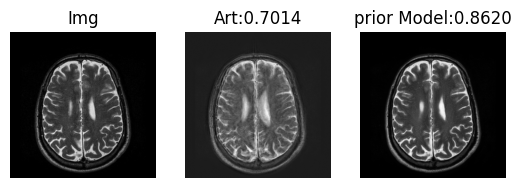

In [ ]:
from ThreeEnc_SumSeDec_See_priorFreq import  *
model = ThreeEnc_SumSeDecModel_init()#.cuda()

model = torch.load("/media/marina/01DB47DC6EBB7DC0/ABONA_MEENA_ALL/ABONA_MEENA/ⲯⲯⲯⲯⲯ/B_ThreeEnc_SumSeDec_See_priorFreq/model_Final/50model.pt","cpu")
print(get_n_params(model))
p = 5881#random.randint(0,len(dataset_val))
print(p)
sample= dataset_val[p]
device = 'cpu'

with torch.no_grad():
    Art = sample['Art'][None].to(device)
    bef = sample['befArt'][None].to(device)
    aft = sample['aftArt'][None].to(device)

    HGH = sample['HighFreqArt'][None].to(device)
    befHGH = sample['HighFreq_befArt'][None].to(device)
    aftHGH = sample['HighFreq_aft_art'][None].to(device)
    Arr = sample['Arr'][None].to(device)

    out = model(torch.concat((bef,Art,aft),1),
                 torch.concat((befHGH,HGH,aftHGH),1))   

    # 1. ssim the high freq
    print("Method 1")
    print(float(ssim_calc(FREQ_WaveLet(Arr)[1],FREQ_WaveLet(Art)[1])))
    print(float(ssim_calc(FREQ_WaveLet(Arr)[1],FREQ_WaveLet(out)[1])))

    # 2. Mse fft : https://arxiv.org/pdf/2108.05054 p.5
    print("Method 2")
    criterion = torch.nn.L1Loss()
    label_fft1 = torch.fft.fft2(Arr)
    pred_fft1 = torch.fft.fft2(out)
    f1 = criterion(pred_fft1, label_fft1)
    print(f1)

    print("Haar")
    def norm_0_1(arr):
        arr = ((arr - arr.min()) / (arr.max()-arr.min()))
        return arr
    from shared.Haar import haarpsi
    print(haarpsi( norm_0_1(sample['Art'][None])[0,0],norm_0_1((out)[0,0]),  C=5, α=4.9)[0])
    
    plot_3_Imgs((sample['Arr'][None])[0,0],(sample['Art'][None])[0,0],(out)[0,0]
                ,title1="Img", title2="Art:", title3="prior Model:", rotate=True)


## Loss & Optimization

In [ ]:
from shared.GradualWarmupSchedulerFile import *
from shared.ssim import SSIM

criterion = SSIM().cuda() #mean absolute error
optimizer = torch.optim.SGD(model.parameters(),
                      lr=0.5,
                      momentum=0.9, # Beta: fraction of past grads
                      weight_decay=5*10**(-5)) # multiplied by whole weight to reduce overfitting



#Decays the learning rate of each parameter group by gamma every step_size epochs.
# run on kaggle for first 20 epochs; then used on kolea until epoch 32
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# this used after that from epoch 33 to epoch 50
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)



# increase LR each epoch
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1.0,
                                           total_epoch=20,
                                             after_scheduler=exp_lr_scheduler)

In [ ]:
# learningRate  = 0.001
# import math
# def scheduler(epoch):
# 	ep = 10
# 	if epoch < ep:
# 		return learningRate
# 	else:
# 		return learningRate * math.exp(0.1 * (ep - epoch)) # lr decreases exponentially by a factor of 10

## Training

In [ ]:
for epoch in range(33):
    scheduler_warmup.step()

In [ ]:
num_epochs = 80

for epoch in range(33,num_epochs):

    model.train()
    ssim_all = 0

    pbar_train = tqdm(enumerate(dataloaders['train']), total=len(dataloaders['train']), position=0, leave=True)
    for (i, data) in pbar_train:

        optimizer.zero_grad()
        
        inp = Variable(data['Art']).to(device)
        bef = Variable(data['befArt']).to(device)
        aft = Variable(data['aftArt']).to(device)
        HGH = Variable(data['HighFreqArt']).to(device)
        befHGH = Variable(data['HighFreq_befArt']).to(device)
        aftHGH = Variable(data['HighFreq_aft_art']).to(device)
        
        outputs_train = model(torch.concat((bef,inp,aft),1),
                                torch.concat((befHGH,HGH,aftHGH),1))   
        
        Arr = Variable(data['Arr'].to(device))
        loss_train = 1-criterion(outputs_train, Arr)
        loss_train.backward()
        
        optimizer.step()

        ssim_all += float((  -(loss_train-1)  ).cpu().detach())

        if(i%10==0):
            if((i==0) and (epoch==0)):
                file1 = open(path_model + "log.txt", "w")
            else:
                file1 = open(path_model + "log.txt", "a")
            file1.write("Epoch: " + str(epoch)+ "  , step: " + str(i) + "  , SSIM: " + str(float(ssim_all/(i+1))) + "\n")
            file1.close()

    
    print("Train SSIM: " ,ssim_all/len(pbar_train))
    file1 = open(path_model + "log.txt", "a")
    file1.write("Epoch: " + str(epoch)+ "  , Train: " + "  , SSIM: " + str(float(ssim_all/len(pbar_train))) + "\n")
    file1.close()

    torch.save(model, path_model+"/"+str(epoch)+"model.pt")

    scheduler_warmup.step()

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
    with torch.no_grad():
      ssim_all = 0
      pbar_test = tqdm(enumerate(dataloaders['val']), total=len(dataloaders['val']), position=0, leave=True)
      for (i, datatest) in pbar_test:

            Art = Variable(datatest['Art']).to(device)
            bef = Variable(datatest['befArt']).to(device)
            aft = Variable(datatest['aftArt']).to(device)

            HGH = Variable(datatest['HighFreqArt']).to(device)
            befHGH = Variable(datatest['HighFreq_befArt']).to(device)
            aftHGH = Variable(datatest['HighFreq_aft_art']).to(device)

            outputs_test = model(torch.concat((bef,Art,aft),1),
                                    torch.concat((befHGH,HGH,aftHGH),1))   
            
            Arr = Variable(datatest['Arr'].to(device))
            ssim_all +=  float(criterion(outputs_test, Arr).cpu().detach())


      print("Test SSIM: " ,ssim_all/len(pbar_test))

      file1 = open(path_model + "log.txt", "a")
      file1.write("Epoch: " + str(epoch)+ "  , Test: " + "  , SSIM: " + str(float(ssim_all/len(pbar_test))) + "\n")
      file1.close()